<a href="https://colab.research.google.com/github/bodadaniel/Sentiment-analysis/blob/main/NLP_data_bert_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Amazon 2018 automotive
import pandas as pd
import gzip
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


from google.colab import drive 
drive.mount('/content/gdrive')

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df_train = getDF('/content/gdrive/MyDrive/Colab Notebooks/NLP/Automotive_5.json.gz')
df_train = df_train[['reviewerName', 'reviewText', 'overall', 'summary', 'reviewTime']]
df_train['sample_type'] = "automotive"
df_train = df_train.sample(n=int(1e6), random_state=1, ignore_index = True)
#df_train

In [ ]:
#Amazon 2018 Video Games
df_test = getDF('/content/gdrive/MyDrive/Colab Notebooks/NLP/Video_Games_5.json.gz')
df_test = df_test[['reviewerName', 'reviewText', 'overall', 'summary', 'reviewTime']]
df_test['sample_type'] = "video_games"
df_test = df_test.sample(n=int(1e5), random_state=1, ignore_index = True)
#df_test

In [ ]:
df = pd.concat((df_train, df_test), axis = 0)
df.reset_index(inplace = True, drop= True )
df

,reviewerName,reviewText,overall,summary,reviewTime,sample_type
0,aardvark,Made new radio install a breeze. Match up the ...,5.0,Perfect fit,"01 14, 2014",automotive
1,Heather Falwell,Love it,4.0,Four Stars,"10 29, 2014",automotive
2,Amazon Customer,look good,5.0,Five Stars,"09 4, 2014",automotive
3,Ilo O. Kratins,Great traction on and off-road on XR650L in al...,5.0,Great tire for XR650L,"03 22, 2018",automotive
4,Informed shopper,"Looks great. However, the light is a little s...",4.0,Looks great. However,"09 23, 2017",automotive
...,...,...,...,...,...,...
1099995,Adilia13,Bought this for my son. He loves it.,5.0,Five Stars,"03 22, 2017",video_games
1099996,Jason in NC.,As soon as I get the extra hand controls to pl...,5.0,... to play this thing I'm sure it will be fun...,"03 23, 2016",video_games
1099997,Ramon Martinez,Excellent...,5.0,Five Stars,"09 22, 2014",video_games
1099998,Amazon Customer,There seems to be some problem with the pink. ...,3.0,Xbox 360 Rechargeable Controller Battery Pack ...,"02 15, 2014",video_games


In [ ]:
df['reviewTextLength'] = df.reviewText.str.len()
df = df[df.overall != 3]
df.overall = df.overall.map({1:0, 2:0, 4:1, 5:1})
df

In [ ]:
#Modify data 
df = df[(df.reviewTextLength > 1e1) & (df.reviewTextLength < 4e3)]
df['reviewText'] = df['reviewText'].str.slice(0,1000) #512
df['reviewTextLength'] = df.reviewText.str.len()
df.reset_index(drop = True, inplace = True)

In [ ]:
train_df, val_df, test_df = np.split(df.sample(frac=1, random_state=1), [int(.6*len(df)), int(.8*len(df))])

train_df = train_df.sample(n=int(2e5), random_state=1, ignore_index = True)
val_df = val_df.sample(n=int(4e4), random_state=1, ignore_index = True)
test_df = test_df.sample(n=int(1e4), random_state=1, ignore_index = True)

print(train_df.shape, val_df.shape, test_df.shape)

(200000, 7) (40000, 7) (10000, 7)


In [ ]:

! pip install transformers

from tqdm.auto import tqdm,trange

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import numpy as np

from matplotlib import pyplot

#! pip install transformers
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from transformers import BertModel

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')


Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:

def plot_loss(train_losses, valid_losses):
  fig = plt.figure(figsize=(10,6))
  ax = fig.add_subplot(1,1,1)
  ax.plot(train_losses, label='Train loss', color = 'blue')
  ax.plot(valid_losses, label='Valid loss', color = 'green')
  plt.legend()
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Loss')
  ax.set_title(f'Loss function (epoch)')

plot_loss(train_losses = [0.7, 0.8, 0.9], valid_losses = [0.4, 0.5, 0.6])

def plot_accuracy(train_accuracy, valid_accuracy):
  fig = plt.figure(figsize=(10,6))
  ax = fig.add_subplot(1,1,1)
  ax.plot(train_accuracy, label='Train accuracy', color = 'blue')
  ax.plot(valid_accuracy, label='Valid accuracy', color = 'green')
  plt.legend()
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Accuracy')
  ax.set_title(f'Accuracy (epoch)')

plot_accuracy(train_accuracy = [0.7, 0.8, 0.9], valid_accuracy = [0.4, 0.5, 0.6])

In [ ]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = df['overall'].values
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['reviewText']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [ ]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5, freeze_bert=True):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 2)
        self.relu = nn.ReLU()

        if freeze_bert:
          for param in self.bert.parameters():
              param.requires_grad = False

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [ ]:
from datetime import datetime

def train(model, train_data, val_data, learning_rate, epochs, bs = 2):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=bs, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=bs)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    #optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate)
    optimizer = torch.optim.AdamW(model.parameters(), lr= learning_rate)
    
    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    total_acc_train_list = []
    total_loss_train_list = []

    total_acc_val_list = []
    total_loss_val_list = []

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                #print(train_label.dtype)
                #train_label = train_label.type(torch.FloatTensor) 
                train_label = train_label.type(torch.LongTensor) 
                #print(train_label.dtype)

                train_label = train_label.to(device)

                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()
                
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    #print(val_label.dtype)
                    #val_label = val_label.type(torch.FloatTensor) 
                    val_label = val_label.type(torch.LongTensor) 
                    #print(val_label.dtype)

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc

            total_loss_train_list.append((total_loss_train / len(train_data)))
            total_loss_val_list.append((total_loss_val / len(val_data)))

            total_acc_train_list.append((total_acc_train / len(train_data)))
            total_acc_val_list.append((total_acc_val / len(val_data)))

            print(f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} | Train Accuracy: {total_acc_train / len(train_data): .3f} | Val Loss: {total_loss_val / len(val_data): .3f} | Val Accuracy: {total_acc_val / len(val_data): .3f} | End: {datetime.now()}')
    
    #print(type(total_loss_train_list), type(total_acc_train_list), type(total_loss_val_list), type(total_acc_val_list))
    #print(total_loss_train_list, total_loss_val_list, total_acc_train_list, total_acc_val_list)
    plot_loss(train_losses = total_loss_train_list, valid_losses = total_loss_val_list)
    plot_accuracy(train_accuracy = total_acc_train_list, valid_accuracy = total_acc_val_list)


In [ ]:
def evaluate(model, test_data, bs = 2):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=bs)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    pred = []
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
              pred.append(output.argmax(dim=1).item())
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')

    return(pred)

In [ ]:
def count_parameters(model):
    print(f'trainable pars: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')
    print(f'non-trainable pars: {sum(p.numel() for p in model.parameters() if p.requires_grad == False):,}')

In [ ]:
#AdamW, Bert model gradient required on all parameters with small batch size
EPOCHS = 4
model = BertClassifier(freeze_bert=False)
LR = 1e-6

count_parameters(model)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


trainable pars: 108,311,810
non-trainable pars: 0


train_df shape: (200000, 7) | val_df_df.shape: (40000, 7)
Start:  2022-05-07 20:21:27.812180


  0%|          | 0/100000 [00:00<?, ?it/s]

Epochs: 1 | Train Loss:  0.049 | Train Accuracy:  0.963 | Val Loss:  0.037 | Val Accuracy:  0.972 | End: 2022-05-08 00:19:39.002035


  0%|          | 0/100000 [00:00<?, ?it/s]

Epochs: 2 | Train Loss:  0.026 | Train Accuracy:  0.981 | Val Loss:  0.037 | Val Accuracy:  0.974 | End: 2022-05-08 04:14:43.829328


  0%|          | 0/100000 [00:00<?, ?it/s]

Epochs: 3 | Train Loss:  0.012 | Train Accuracy:  0.993 | Val Loss:  0.045 | Val Accuracy:  0.973 | End: 2022-05-08 08:09:53.111603


  0%|          | 0/100000 [00:00<?, ?it/s]

Epochs: 4 | Train Loss:  0.005 | Train Accuracy:  0.997 | Val Loss:  0.070 | Val Accuracy:  0.971 | End: 2022-05-08 12:04:51.385491


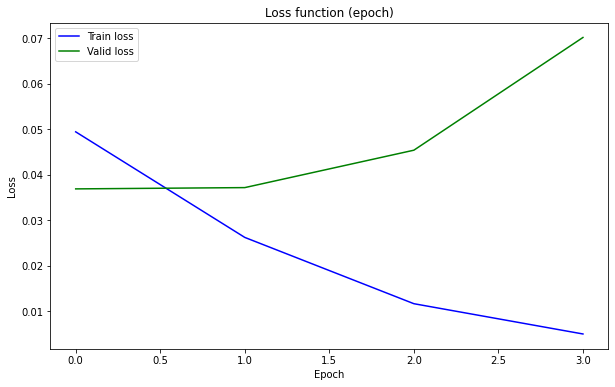

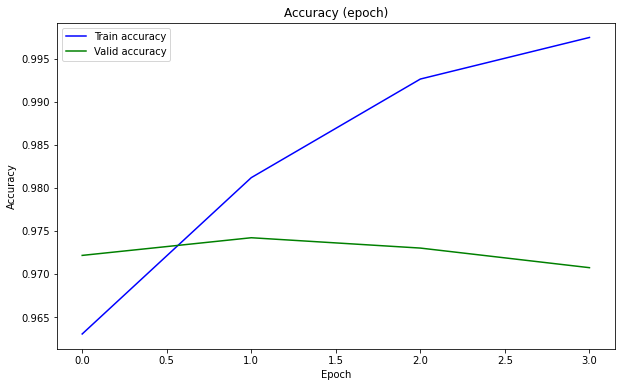

In [ ]:
#1-th:
print(f'train_df shape: {train_df.shape} | val_df_df.shape: {val_df.shape}')
print('Start: ', datetime.now())
train(model, train_df, val_df, LR, EPOCHS, bs = 2)  

In [ ]:
pred = evaluate(model, test_df, bs=1)

Test Accuracy:  0.968


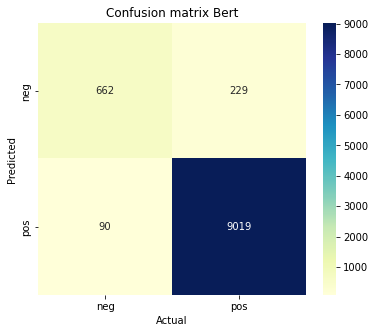

In [ ]:
cm=confusion_matrix(test_df.overall, pred)
plt.figure(figsize=(6, 5))
ax = plt.axes()
sns.heatmap(cm, annot=True, xticklabels=["neg", "pos"], yticklabels=["neg", "pos"], fmt="g", cmap="YlGnBu",  ax = ax)
ax.set_title('Confusion matrix Bert')
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.show()

In [ ]:
#pred = test_df.overall

submission_df1 = pd.DataFrame({'id': list(range(test_df.shape[0])), 'pred': pred})
print(submission_df1.shape)

submission_df1.to_csv('/content/gdrive/MyDrive/Colab Notebooks/NLP/Bert_pred.csv', index = False)
np.savetxt('/content/gdrive/MyDrive/Colab Notebooks/NLP/Bert_pred.txt', submission_df1, fmt='%d')


(10000, 2)
